# Testing Rolling Gerber

Diego Alvarez<br> diego.alvarez@colorado.edu

# Packages

In [5]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt

# Accessing Gerber Object

In [3]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))
from Gerber import Gerber

# Collect Data

In [6]:
df = (yf.download(
    tickers = ["TLT", "SPY"], 
    start = dt.date(year = 1980, month = 1, day = 1),
    end = dt.date.today())
    ["Adj Close"].
    pct_change().
    dropna())

[*********************100%***********************]  2 of 2 completed


# Calculate Rolling Gerber Correlation vs. Rolling Correlation

In [16]:
df_rolling_gerber = Gerber(rtns = df).rolling_gerber_corr(window = 252)
df_rolling_corr = df.assign(rolling_corr = lambda x: x["SPY"].rolling(window = 252).corr(x["TLT"]))

df_combined = (df_rolling_gerber.reset_index().merge(
    right = df_rolling_corr["rolling_corr"].reset_index(),
    how = "inner",
    on = "Date").
    set_index("Date"))

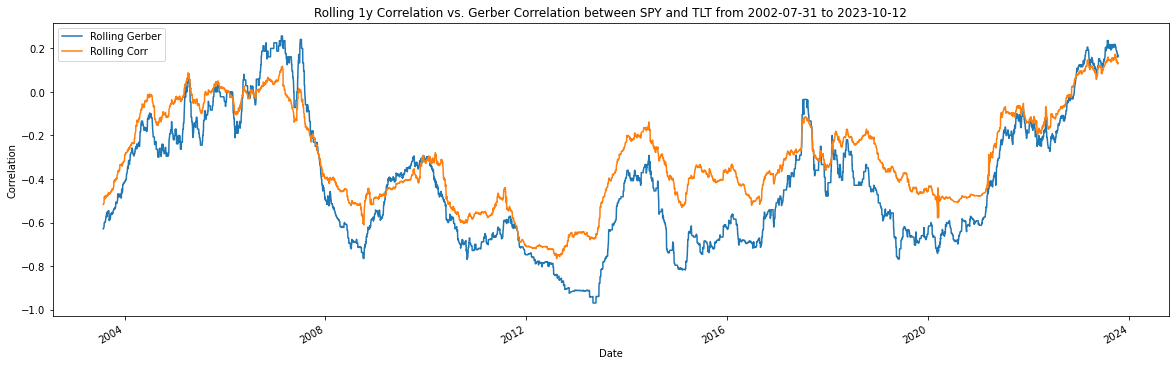

In [38]:
(df_combined.rename(columns = {
    "gerber_stat": "Rolling Gerber",
    "rolling_corr": "Rolling Corr"}).
    plot(
        figsize = (20,6),
        ylabel = "Correlation",
        title = "Rolling 1y Correlation vs. Gerber Correlation between SPY and TLT from {} to {}".format(
            df_combined.index.min().date(),
            df_combined.index.max().date())))

plt.show()

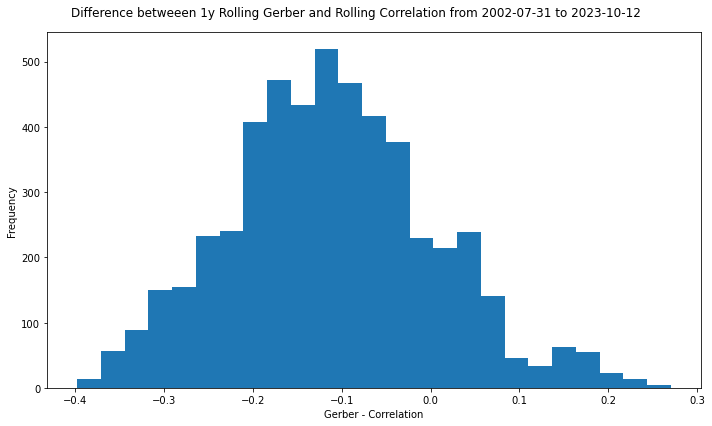

In [52]:
df_spread = df_combined.assign(spread = lambda x: x.gerber_stat - x.rolling_corr)

fig, axes = plt.subplots(figsize = (10,6))    
(df_spread["spread"].plot(
    kind = "hist",
    bins = 25,
    ax = axes))

axes.set_xlabel("Gerber - Correlation")
fig.suptitle("Difference betweeen 1y Rolling Gerber and Rolling Correlation from {} to {}".format(
    df_combined.index.min().date(),
    df_combined.index.max().date()))

plt.tight_layout()

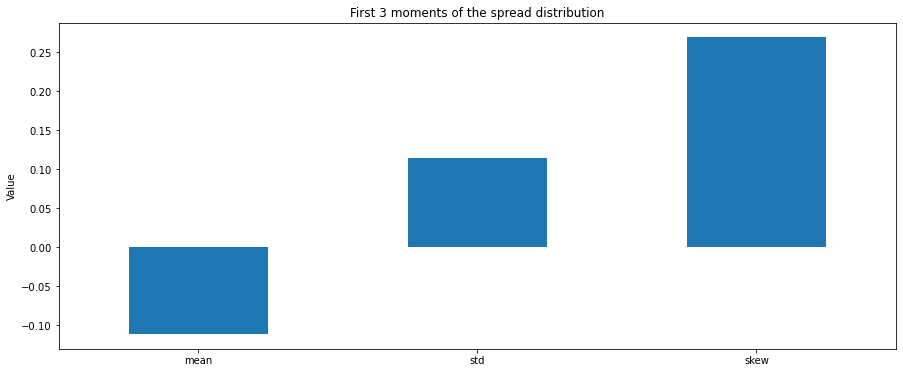

In [60]:
(df_spread[
    ["spread"]].
    dropna().
    reset_index().
    melt(id_vars = "Date").
    groupby("variable").
    agg(["mean", "std", "skew"])
    ["value"].
    T.
    plot(
        kind = "bar",
        legend = False,
        title = "First 3 moments of the spread distribution",
        figsize = (15,6),
        ylabel = "Value",
        rot = 0))

plt.show()